# Chain

## Review

We built a simple graph with nodes, normal edges, and conditional edges.

## Goals

Now, let's build up to a simple chain that combines 4 [concepts](https://python.langchain.com/v0.2/docs/concepts/):

* Using [chat messages](https://python.langchain.com/v0.2/docs/concepts/#messages) as our graph state
* Using [chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) in graph nodes
* [Binding tools](https://python.langchain.com/v0.2/docs/concepts/#tools) to our chat model
* [Executing tool calls](https://python.langchain.com/v0.2/docs/concepts/#functiontool-calling) in graph nodes

![Screenshot 2024-08-21 at 9.24.03 AM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dd607b08df5e1101_chain1.png)

In [4]:
%%capture --no-stderr
%pip install --quiet -U langchain_openai langchain_core langgraph langchain_groq

## Messages

Chat models can use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages), which capture different roles within a conversation.

LangChain supports various message types, including `HumanMessage`, `AIMessage`, `SystemMessage`, and `ToolMessage`.

These represent a message from the user, from chat model, for the chat model to instruct behavior, and from a tool call.

Let's create a list of messages.

Each message can be supplied with a few things:

* `content` - content of the message
* `name` - optionally, a message author
* `response_metadata` - optionally, a dict of metadata (e.g., often populated by model provider for `AIMessages`)

In [2]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


## Chat Models

[Chat models](https://python.langchain.com/v0.2/docs/concepts/#chat-models) can use a sequence of message as input and support message types, as discussed above.

There are [many](https://python.langchain.com/v0.2/docs/concepts/#chat-models) to choose from! Let's work with OpenAI.

Let's check that your `OPENAI_API_KEY` is set and, if not, you will be asked to enter it.

In [5]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("GROQ_API_KEY")

GROQ_API_KEY: ··········


We can load a chat model and invoke it with out list of messages.

We can see that the result is an `AIMessage` with specific `response_metadata`.

In [6]:
from langchain_groq import ChatGroq
llm = ChatGroq(model="openai/gpt-oss-120b")
result = llm.invoke(messages)
type(result)

langchain_core.messages.ai.AIMessage

In [7]:
result

AIMessage(content='### Best U.S. Spots to See Orcas (Killer Whales)\n\n| State | Top Locations | Why It’s Great | Best Time of Year | Typical Tour Options |\n|-------|---------------|----------------|-------------------|----------------------|\n| **Washington** | **San Juan Islands** (especially Friday Harbor & Lime Kiln) <br> **Northwest Straits (Puget Sound)** <br> **Whidbey Island** (near Deception Pass) | • Highest concentration of resident “Southern Resident” pods (J‑, K‑, and L‑pods). <br>• Calm, sheltered waters make sightings frequent. <br>• Well‑developed eco‑tour industry with knowledgeable guides. | **April\u202f–\u202fOctober** (peak: May‑September). <br>Winter months can be foggy and seas rough, reducing visibility. | • Day‑long or half‑day boat tours (30‑min to 3‑hr). <br>• Kayak excursions (advanced paddlers). <br>• Whale‑watching ferries (e.g., San Juan Safaris, Northwest Adventures). |\n| **Alaska** | **Juneau** (Auke Bay) <br> **Glacier Bay National Park** <br> **Sitk

In [8]:
result.response_metadata

{'token_usage': {'completion_tokens': 1795,
  'prompt_tokens': 127,
  'total_tokens': 1922,
  'completion_time': 3.803497477,
  'prompt_time': 0.029376183,
  'queue_time': 1.001152941,
  'total_time': 3.8328736599999997},
 'model_name': 'openai/gpt-oss-120b',
 'system_fingerprint': 'fp_91af62a853',
 'service_tier': 'on_demand',
 'finish_reason': 'stop',
 'logprobs': None}

## Tools

Tools are useful whenever you want a model to interact with external systems.

External systems (e.g., APIs) often require a particular input schema or payload, rather than natural language.

When we bind an API, for example, as a tool we given the model awareness of the required input schema.

The model will choose to call a tool based upon the natural language input from the user.

And, it will return an output that adheres to the tool's schema.

[Many LLM providers support tool calling](https://python.langchain.com/v0.1/docs/integrations/chat/) and [tool calling interface](https://blog.langchain.dev/improving-core-tool-interfaces-and-docs-in-langchain/) in LangChain is simple.

You can simply pass any Python `function` into `ChatModel.bind_tools(function)`.

![Screenshot 2024-08-19 at 7.46.28 PM.png](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66dbab08dc1c17a7a57f9960_chain2.png)

Let's showcase a simple example of tool calling!

The `multiply` function is our tool.

In [9]:
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

llm_with_tools = llm.bind_tools([multiply])

If we pass an input - e.g., `"What is 2 multiplied by 3"` - we see a tool call returned.

The tool call has specific arguments that match the input schema of our function along with the name of the function to call.

```
{'arguments': '{"a":2,"b":3}', 'name': 'multiply'}
```

In [10]:
tool_call = llm_with_tools.invoke([HumanMessage(content=f"What is 2 multiplied by 3", name="Lance")])

In [11]:
tool_call.tool_calls

[]

## Using messages as state

With these foundations in place, we can now use [`messages`](https://python.langchain.com/v0.2/docs/concepts/#messages) in our graph state.

Let's define our state, `MessagesState`, as a `TypedDict` with a single key: `messages`.

`messages` is simply a list of messages, as we defined above (e.g., `HumanMessage`, etc).

In [12]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage

class MessagesState(TypedDict):
    messages: list[AnyMessage]

## Reducers

Now, we have a minor problem!

As we discussed, each node will return a new value for our state key `messages`.

But, this new value [will override](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) the prior `messages` value.

As our graph runs, we want to **append** messages to our `messages` state key.

We can use [reducer functions](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) to address this.

Reducers allow us to specify how state updates are performed.

If no reducer function is specified, then it is assumed that updates to the key should *override it* as we saw before.

But, to append messages, we can use the pre-built `add_messages` reducer.

This ensures that any messages are appended to the existing list of messages.

We simply need to annotate our `messages` key with the `add_messages` reducer function as metadata.

In [13]:
from typing import Annotated
from langgraph.graph.message import add_messages

class MessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

Since having a list of messages in graph state is so common, LangGraph has a pre-built [`MessagesState`](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate)!

`MessagesState` is defined:

* With a pre-build single `messages` key
* This is a list of `AnyMessage` objects
* It uses the `add_messages` reducer

We'll usually use `MessagesState` because it is less verbose than defining a custom `TypedDict`, as shown above.

In [14]:
from langgraph.graph import MessagesState

class MessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    pass

To go a bit deeper, we can see how the `add_messages` reducer works in isolation.

In [15]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='dd880a0e-e5a3-468e-9c0a-c7cd0183ef9e'),
 HumanMessage(content="I'm looking for information on marine biology.", additional_kwargs={}, response_metadata={}, name='Lance', id='db20e36f-0de9-407e-b506-41439c86be1f'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='f7864803-ae8f-4875-b27a-873e47bb019b')]

## Our graph

Now, lets use `MessagesState` with a graph.

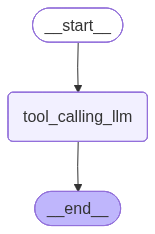

In [16]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

If we pass in `Hello!`, the LLM responds without any tool calls.

In [19]:
messages = graph.invoke({"messages": HumanMessage(content="Hello!")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Hello!
================================== Ai Message ==================================

Hello! How can I assist you today?


The LLM chooses to use a tool when it determines that the input or task requires the functionality provided by that tool.

In [21]:
messages = graph.invoke({"messages": HumanMessage(content="Multiply 2 and 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (fc_8a2b210e-55a1-4b63-85e3-07a28657674d)
 Call ID: fc_8a2b210e-55a1-4b63-85e3-07a28657674d
  Args:
    a: 2
    b: 3


# MY EXAMPLE:

Create a Python function that performs addition


In [22]:
def add(a: int, b: int) -> int:
    """Add two integers.

    Args:
        a: The first integer.
        b: The second integer.
    """
    return a + b

Update the `llm_with_tools` object to include the newly defined `add` tool in addition to the existing `multiply` tool.


In [23]:
llm_with_tools = llm.bind_tools([multiply, add])

Modify the `tool_calling_llm` function to handle the new tool call if the language model chooses to use it.


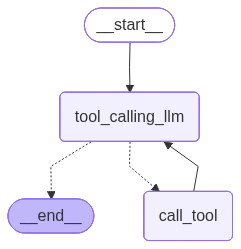

In [ ]:
from langchain_core.messages import ToolMessage
import json

def call_tool(state: MessagesState):
    last_message = state["messages"][-1]
    tool_messages = []
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        for tool_call in last_message.tool_calls:
            tool_name = tool_call["name"]
            tool_args = tool_call["args"] # Use the args directly as it's already a dict
            if tool_name == "multiply":
                tool_result = multiply(**tool_args)
            elif tool_name == "add":
                tool_result = add(**tool_args)
            else:
                tool_result = f"Unknown tool: {tool_name}"

            tool_messages.append(ToolMessage(content=str(tool_result), tool_call_id=tool_call["id"]))
    return {"messages": tool_messages}

# Update graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("call_tool", call_tool)

builder.add_edge(START, "tool_calling_llm")

# Conditional edge from tool_calling_llm
def should_continue(state: MessagesState):
    last_message = state["messages"][-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "call_tool"
    else:
        return END

builder.add_conditional_edges(
    "tool_calling_llm",
    should_continue,
    {
        "call_tool": "call_tool",
        END: END
    }
)

builder.add_edge("call_tool", "tool_calling_llm")

graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

Invoke the graph with an input that triggers the new tool


In [31]:
# Invoke the graph with an input that triggers the new tool
messages = graph.invoke({"messages": HumanMessage(content="What is 5 plus 7")})

Display the results


In [32]:
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 5 plus 7
================================== Ai Message ==================================

5 + 7 = 12.
